In [5]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.patches import Ellipse

from abc import ABC, abstractmethod

In [6]:
class Neuron:
    def __init__(self, mean, cov, coord):
        self.mean_ = mean
        self.cov_ = cov
        self.coord_ = coord

In [7]:
class Lattice(ABC):
    def __init__(self, size):
        self.size_ = size
        self.neurons_ = None
        self.neurons_nb_ = None

        self.generate()

    @abstractmethod
    def generate(self):
        pass


class RectangularLattice(Lattice):
    def generate(self):
        self.neurons_ = []
        self.neurons_nb_ = self.size_[0] * self.size_[1]

        for i in range(0, self.size_[0]):
            for j in range(0, self.size_[1]):
                self.neurons_.append(Neuron(None, None, np.array([i, j])))


In [70]:
class SOMM:
    def __init__(self, lattice: Lattice, learning_rate):
        self.learning_rate_ = learning_rate
        self.alpha_ = None
        self.lattice_ = lattice

    def fit(self, X: np.ndarray, epochs):
        neurons_nb = self.lattice_.neurons_nb_
        neurons = self.lattice_.neurons_

        indexes = np.random.choice(X.shape[0], neurons_nb, replace=False)

        for i in range(0, neurons_nb):
            neurons[i].mean_ = X[indexes[i]]
            neurons[i].cov_ = self.initialize_cov(X.shape[1])
            print(neurons[i].cov_)

        for ep in range(epochs):
            self.alpha_ = np.sqrt(ep + 1) * self.learning_rate_
            print("Epoch:", ep)
            print("1/2*sigma^2:", self.alpha_)
            print("Weights, Covariance:")
            for neuron in self.lattice_.neurons_:
                print(neuron.mean_, end=' ')
                #print(neuron.cov_, end=' ')
            print()

            bmus_idx = []
            for x in X:
                # Find best matching unit for x_n
                winner_idx = self.find_bmu(x)
                bmus_idx.append(winner_idx)

            # Update nodes
            self.update_nodes(bmus_idx, X)

    def neighbourhood_func(self, r, s):
        # r - fixed neuron index
        # s - arbitrary neuron index

        numerator = np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, self.lattice_.neurons_[s].coord_))
        denominator = 0

        for neuron in self.lattice_.neurons_:
            denominator += np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, neuron.coord_))

        return numerator / denominator

    def find_bmu(self, x):
        # returns winner_idx
        min_d = np.inf
        winner_idx = None

        for i in range(self.lattice_.neurons_nb_):
            d = self.bmu_distance(x, i)
            if d < min_d:
                min_d = d
                winner_idx = i

        return winner_idx

    @staticmethod
    def distance(v1: np.ndarray, v2: np.ndarray):
        # Calculating euclidian distance
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def bmu_distance(self, x, neuron_idx):
        distance = 0
        for i, neuron in enumerate(self.lattice_.neurons_):
            nb_val = self.neighbourhood_func(neuron_idx, i)

            #distance += nb_val * (self.distance(x, self.lattice_.neurons_[i].mean_) / 2 + np.log(nb_val))
            distance += nb_val * ((np.log(np.linalg.det(neuron.cov_)) + (x - neuron.mean_).T @ np.linalg.inv(neuron.cov_) @ (x - neuron.mean_))/2 + np.log(nb_val))

        return distance

    def update_nodes(self, bmus_idx, X):
        # Updating all neuron based on batch mode

        for neuron_idx in range(self.lattice_.neurons_nb_):
            numerator_mean = 0
            numerator_cov = 0
            denominator = 0

            for i, x in enumerate(X):
                nb_val = self.neighbourhood_func(bmus_idx[i], neuron_idx)

                numerator_cov += nb_val * np.outer((x - self.lattice_.neurons_[neuron_idx].mean_), (x - self.lattice_.neurons_[neuron_idx].mean_))
                numerator_mean += nb_val * x
                denominator += nb_val

            self.lattice_.neurons_[neuron_idx].mean_ = numerator_mean / denominator
            self.lattice_.neurons_[neuron_idx].cov_ = (numerator_cov / denominator).reshape(X.shape[1], X.shape[1])
            
    
    @staticmethod
    def initialize_cov(n):
        upper_triangle_values = np.random.rand(n * (n - 1) // 2)

        # Construct the full covariance matrix by filling both upper and lower triangles
        cov_matrix = np.zeros((n, n))
        cov_matrix[np.triu_indices(n, k=1)] = upper_triangle_values
        cov_matrix = cov_matrix + cov_matrix.T

        # # Set the diagonal elements to 1
        np.fill_diagonal(cov_matrix, 1.0)
        return cov_matrix

### Example 1

Text(0.5, 1.0, '1D Gaussian Mixture Dataset')

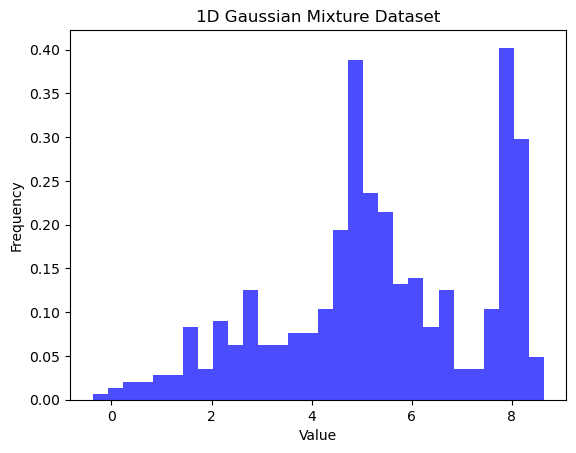

In [23]:
# Define the parameters for the Gaussian mixture
means = np.array([3, 5, 6, 8])
variances = np.array([1.2, 0.4, 0.9, 0.2])
n_samples = 120

# Generate data points from the Gaussian mixture
data = np.concatenate([np.random.normal(means[i], variances[i], n_samples) for i in range(len(means))])

# Visualize the generated data
hist_data, bin_edges, _ = plt.hist(data, bins=30, density=True, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Gaussian Mixture Dataset')

In [24]:
data

array([ 2.75002216,  3.9418619 ,  1.64779574,  2.70484604,  1.72033642,
        3.83963486,  3.20915655,  2.78603549,  3.62397154,  2.67511533,
        0.51479607,  3.47040476,  2.16422573,  4.12506561,  3.37163857,
        1.4541963 ,  4.54015378,  4.85438012,  3.70739335,  2.54691035,
        3.51231676,  3.16795911,  2.62877738,  2.02873395,  5.66121795,
        3.14453445,  3.70099018,  2.13700161, -0.37332268,  0.22164906,
        3.31513211,  3.18376769,  5.57937433,  2.06387583,  2.70399694,
        4.47551928,  1.20348976,  2.46185177,  0.45752032,  2.59433579,
        2.29796799,  1.38760615,  1.01579728,  2.78632706,  2.90742937,
        1.5123704 ,  2.78171118,  3.03537886,  0.8197738 ,  4.65942778,
        2.37575721,  3.64244113,  1.66585312,  2.54713857,  1.9354229 ,
        3.92478142,  2.75978092,  2.11829892,  1.98662536,  3.41450447,
        0.3254156 ,  1.6710866 ,  1.92760992,  3.04030263,  3.90208623,
        0.82172913,  3.30052044,  4.35482771,  1.82793323,  2.73

In [25]:
X = data.reshape(-1, 1)
X

array([[ 2.75002216],
       [ 3.9418619 ],
       [ 1.64779574],
       [ 2.70484604],
       [ 1.72033642],
       [ 3.83963486],
       [ 3.20915655],
       [ 2.78603549],
       [ 3.62397154],
       [ 2.67511533],
       [ 0.51479607],
       [ 3.47040476],
       [ 2.16422573],
       [ 4.12506561],
       [ 3.37163857],
       [ 1.4541963 ],
       [ 4.54015378],
       [ 4.85438012],
       [ 3.70739335],
       [ 2.54691035],
       [ 3.51231676],
       [ 3.16795911],
       [ 2.62877738],
       [ 2.02873395],
       [ 5.66121795],
       [ 3.14453445],
       [ 3.70099018],
       [ 2.13700161],
       [-0.37332268],
       [ 0.22164906],
       [ 3.31513211],
       [ 3.18376769],
       [ 5.57937433],
       [ 2.06387583],
       [ 2.70399694],
       [ 4.47551928],
       [ 1.20348976],
       [ 2.46185177],
       [ 0.45752032],
       [ 2.59433579],
       [ 2.29796799],
       [ 1.38760615],
       [ 1.01579728],
       [ 2.78632706],
       [ 2.90742937],
       [ 1

In [26]:
lattice = RectangularLattice((2, 3))
som = SOMM(lattice, 1.005)

In [27]:
som.fit(X, 100)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[5.38373875] [[1.]] [7.86635493] [[1.]] [4.78398684] [[1.]] [5.38520953] [[1.]] [8.04559138] [[1.]] [3.90208623] [[1.]] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[5.8396482] [[1.9905087]] [6.29974003] [[6.20005827]] [5.04406312] [[4.0826369]] [5.70257825] [[3.16821368]] [5.26802567] [[12.61316169]] [3.90695231] [[4.66958128]] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[5.73104455] [[1.21763395]] [6.46360201] [[3.34949672]] [5.13148679] [[5.66826395]] [5.70355428] [[2.43193663]] [5.23948564] [[5.06077727]] [3.34585464] [[4.25534805]] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[5.64852074] [[0.97418943]] [6.95516936] [[2.747301]] [5.33809995] [[6.46863166]] [5.55315495] [[2.18259633]] [4.90314052] [[3.31811619]] [3.0572144] [[3.60897541]] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[5.66480667] [[0.81985009]] [7.11925514] [[2.1078127

In [28]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_, neuron.cov_)

[5.77854948] [[0.05082613]]
[7.98794703] [[0.04363505]]
[6.70053726] [[0.10573161]]
[5.03409661] [[0.04318436]]
[4.14456724] [[0.16087577]]
[2.09508953] [[0.70766572]]


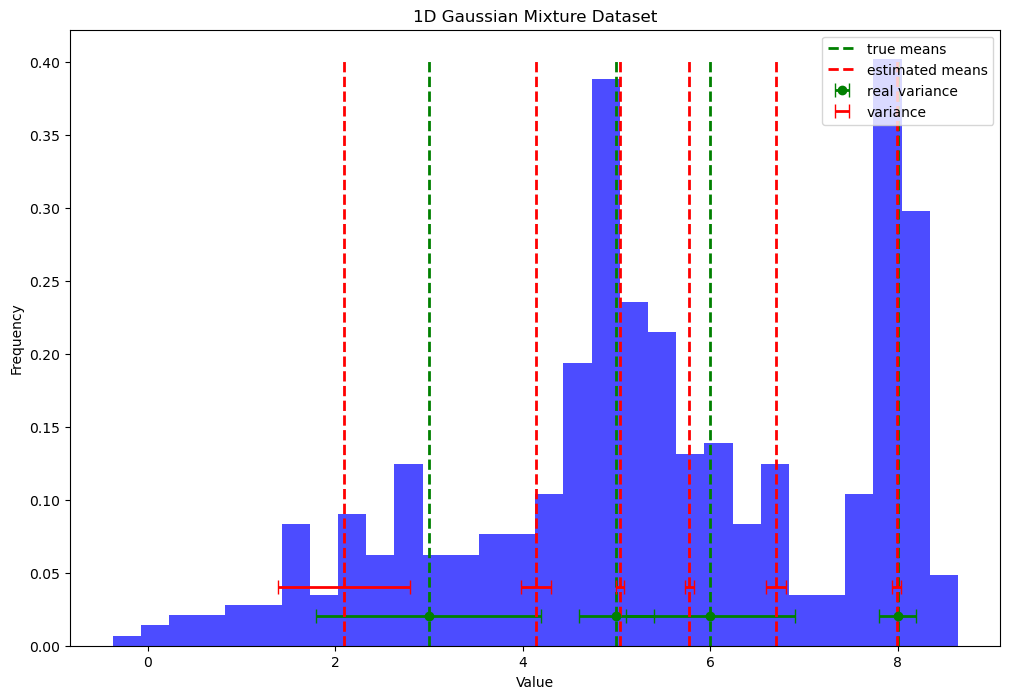

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the generated data
ax.hist(data, bins=30, density=True, alpha=0.7, color='b')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('1D Gaussian Mixture Dataset')

neuron_variances = np.array([neuron.cov_[0] for neuron in som.lattice_.neurons_]).flatten()
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_]).flatten()

# Plot vertical lines for real means:
ax.vlines(x=means, color='g', linestyle='--', linewidth=2, label='true means', ymin=0, ymax=max(hist_data))
ax.errorbar(means, np.full(len(means), max(hist_data) * 0.05), xerr=variances, fmt='go', elinewidth=2, capsize=5, label='real variance')

# Plot vertical lines for neuron weights
ax.vlines(x=neuron_weights, color='r', linestyle='--', linewidth=2, label='estimated means', ymin=0, ymax=max(hist_data))
ax.errorbar(x=neuron_weights, y=np.full(len(neuron_weights), max(hist_data) * 0.1), xerr=neuron_variances, color='r', fmt='none', elinewidth=2, capsize=5, label='variance')


ax.legend(loc='upper right');

### Example 2

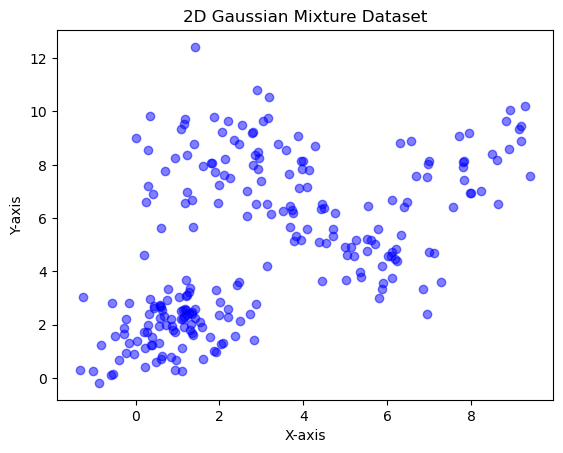

In [9]:
# Define the parameters for the 2D Gaussian mixture
means = np.array([[1, 2], [5, 5], [8, 8], [2, 8]])
covariances = np.array([[[1, 0.5], [0.5, 1]],
                        [[1, -0.5], [-0.5, 1]],
                        [[1, 0.5], [0.5, 1]],
                        [[1.3, 0], [0, 1.3]]])

n_samples = [100, 50, 30, 60]

# Generate data points from the 2D Gaussian mixture
data = np.concatenate([np.random.multivariate_normal(mean, cov, n) for mean, cov, n in zip(means, covariances, n_samples)])

# Visualize the generated data
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Gaussian Mixture Dataset')

plt.show()

In [10]:
data

array([[ 5.48698966e-01,  1.30967729e+00],
       [-1.63596000e-01,  2.81867819e+00],
       [ 2.25707791e-01,  4.21490730e-01],
       [ 4.35067048e-01,  2.68854500e+00],
       [ 1.28225213e+00,  3.22419730e+00],
       [ 9.38616808e-01,  1.74616232e+00],
       [ 2.07574682e+00,  1.30355366e+00],
       [ 1.36591097e+00,  1.61198085e+00],
       [ 5.84953829e-01,  2.73583851e+00],
       [ 4.41684469e-01,  2.64318021e+00],
       [ 1.20004365e+00,  3.67151507e+00],
       [ 1.19768441e+00,  2.55511255e+00],
       [ 1.17621429e+00,  2.57506353e+00],
       [ 5.74484092e-01,  2.26117761e+00],
       [ 2.12050994e-01,  1.71593615e+00],
       [ 1.91561364e+00,  9.94302345e-01],
       [ 8.53833355e-01,  2.19954122e+00],
       [ 6.21201775e-01,  8.26186401e-01],
       [ 1.60288670e+00,  7.19726671e-01],
       [ 1.99617461e+00,  2.35861990e+00],
       [ 1.52865238e+00,  2.11978293e+00],
       [ 7.20959926e-01,  1.97287544e+00],
       [ 2.88269837e+00,  2.76532499e+00],
       [ 2.

In [23]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005)

In [24]:
som.fit(data, 200)

[[1.         0.26505675]
 [0.26505675 1.        ]]
[[1.         0.34814808]
 [0.34814808 1.        ]]
[[1.         0.94016732]
 [0.94016732 1.        ]]
[[1.       0.110242]
 [0.110242 1.      ]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[6.29532602 8.80279847] [[1.         0.26505675]
 [0.26505675 1.        ]] [2.88269837 2.76532499] [[1.         0.34814808]
 [0.34814808 1.        ]] [0.68831783 2.32003276] [[1.         0.94016732]
 [0.94016732 1.        ]] [3.03086099 9.65080558] [[1.       0.110242]
 [0.110242 1.      ]] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[3.94577573 5.45329814] [[14.7197757  13.48328786]
 [13.48328786 19.59028534]] [3.1166967  4.81990794] [[ 6.13131215  2.48537843]
 [ 2.48537843 12.12746633]] [2.17535473 4.02773704] [[ 8.70685209  7.46896886]
 [ 7.46896886 11.20581412]] [2.79009004 5.5414434 ] [[ 5.10234591  3.75060692]
 [ 3.75060692 26.20808279]] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[4.62271597 5.6290224

In [27]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_)
    print(neuron.cov_)
    print()

[7.81892149 8.03766084]
[[1.12431797 0.62295174]
 [0.62295174 1.24183571]]

[5.13129456 5.00463244]
[[ 1.1670956  -0.80828124]
 [-0.80828124  1.1392683 ]]

[0.8940158 1.9429305]
[[0.87679529 0.34666485]
 [0.34666485 0.85280389]]

[2.13462622 8.22261069]
[[1.29169912 0.32221804]
 [0.32221804 1.82987391]]



In [28]:
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])

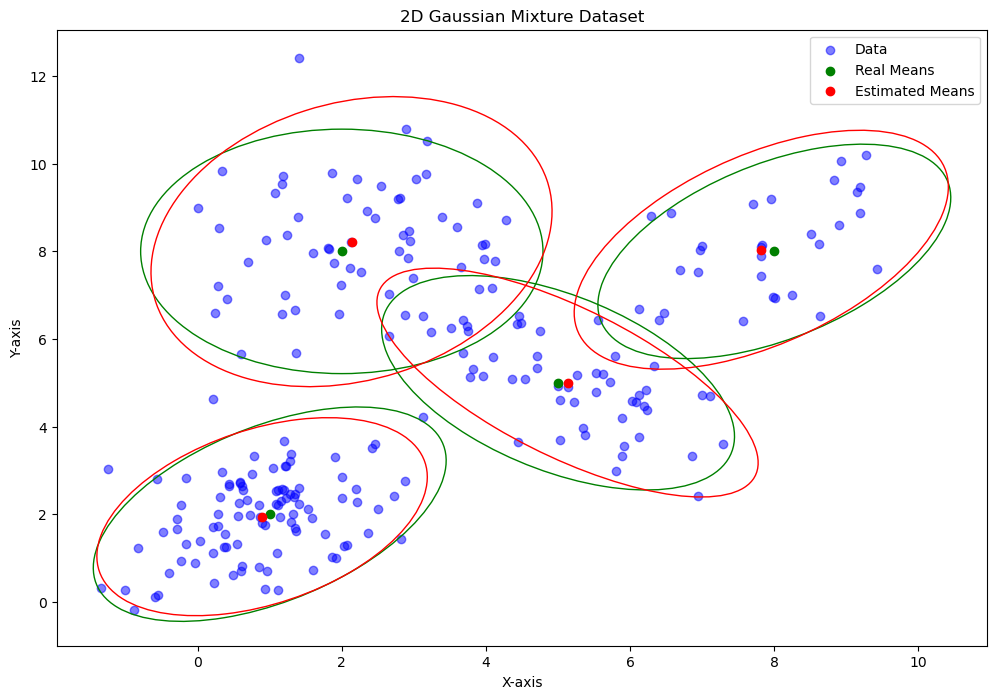

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b', label='Data')

# Plot means as green points
ax.scatter(means[:, 0], means[:, 1], color='g', marker='o', label='Real Means')

# Plot true parameters
for mean, cov in zip(means, covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='g', fill=False)
    ax.add_patch(ell)

# Plot means as red points
ax.scatter(neuron_weights[:, 0], neuron_weights[:, 1], color='r', marker='o', label='Estimated Means')

# Plot neuron parameters
for mean, cov in zip(neuron_weights, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='r', fill=False)
    ax.add_patch(ell)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

### Example 3

In [346]:
def generate_mixture(means, variances, weights, n_samples):
    mixture_idx = np.random.choice(len(weights), size=n_samples, replace=True, p=weights)

    # y is the mixture sample
    data = np.concatenate([np.random.normal(means[i], 1/variances[i]**0.5, size=1) for i in mixture_idx])
    return data, mixture_idx

def generate_data(param1, param2):
    data1, labels1 = generate_mixture(param1[0], param1[1], param1[2], param1[3])
    data2, labels2 = generate_mixture(param2[0], param2[1], param2[2], param2[3])

    data = np.hstack((data1.reshape(-1, 1), data2.reshape(-1, 1)))
    labels = labels1 * len(np.unique(labels2)) + labels2

    return data, labels

In [367]:
n_samples = 500

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([1, 3])
variances1 = np.array([1, 0.5])
weights1 = np.array([0.3, 0.7])
param1 = [means1, variances1, weights1, n_samples]

means2 = np.array([-3, -0.5])
variances2 = np.array([0.8, 0.3])
weights2 = np.array([0.4, 0.6])
param2 = [means2, variances2, weights2, n_samples]


In [368]:
data, labels = generate_data(param1, param2)

In [369]:
data

array([[ 1.61682064e+00, -2.87404647e+00],
       [ 2.40254694e+00,  2.87551508e+00],
       [ 7.90980333e-02, -2.85252618e+00],
       [ 6.67390280e-01,  2.33424367e-01],
       [ 2.48344792e+00,  1.26407375e+00],
       [ 4.99862417e+00,  3.94175110e-01],
       [ 3.56588691e+00, -4.03762372e+00],
       [ 5.77305539e+00, -4.27556894e+00],
       [ 3.50942673e+00, -1.98233387e+00],
       [ 6.87693218e-01, -2.89978996e+00],
       [ 1.46767031e+00, -4.30057025e+00],
       [ 1.12081215e+00,  2.60677202e-01],
       [ 5.79967829e+00,  1.17455666e+00],
       [ 6.84767221e-01, -8.24928467e-01],
       [ 2.97925892e+00, -2.37625958e+00],
       [ 4.78400251e+00, -3.05539218e+00],
       [ 8.60023840e-01, -1.57253932e+00],
       [ 3.96639896e+00, -8.84086349e-01],
       [ 1.22228598e+00,  4.51032295e-01],
       [ 2.27264191e+00, -1.10386776e+00],
       [ 1.50961555e+00, -8.67309163e-01],
       [ 1.53545377e+00, -4.42796783e+00],
       [ 3.82983464e+00, -2.61446609e+00],
       [ 8.

In [370]:
labels

array([2, 1, 2, 1, 3, 3, 2, 2, 2, 3, 0, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 2,
       2, 2, 1, 1, 2, 3, 1, 3, 2, 3, 2, 3, 3, 1, 3, 3, 3, 2, 3, 3, 1, 3,
       2, 1, 3, 1, 3, 3, 1, 1, 3, 2, 1, 3, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 1, 2, 3, 2, 3, 3, 1, 1, 2, 3, 3, 2, 3, 1, 1, 3, 3, 3, 3,
       0, 1, 2, 3, 3, 3, 0, 2, 2, 2, 2, 3, 3, 1, 3, 2, 1, 3, 3, 1, 3, 1,
       0, 3, 1, 1, 2, 1, 3, 2, 1, 2, 3, 0, 1, 3, 3, 2, 2, 1, 3, 3, 2, 3,
       2, 3, 3, 1, 1, 3, 2, 2, 2, 2, 2, 3, 0, 2, 3, 2, 3, 0, 1, 3, 2, 3,
       2, 3, 3, 3, 1, 3, 1, 3, 3, 2, 0, 0, 0, 3, 1, 0, 1, 3, 0, 1, 3, 3,
       1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 2, 3, 3, 3, 0, 3,
       2, 1, 2, 1, 3, 1, 1, 1, 0, 3, 3, 1, 2, 1, 3, 3, 3, 2, 2, 2, 1, 1,
       3, 0, 2, 1, 2, 0, 3, 0, 0, 2, 3, 2, 3, 3, 0, 1, 0, 2, 0, 2, 3, 1,
       2, 3, 2, 3, 0, 3, 2, 0, 1, 2, 2, 3, 1, 3, 2, 1, 3, 3, 2, 0, 1, 3,
       2, 3, 3, 1, 3, 3, 3, 0, 1, 2, 1, 1, 3, 0, 0, 3, 2, 1, 0, 2, 2, 3,
       2, 3, 2, 3, 3, 2, 2, 0, 2, 3, 3, 1, 0, 3, 3,

Text(0.5, 1.0, '2D Gaussian Mixture Dataset')

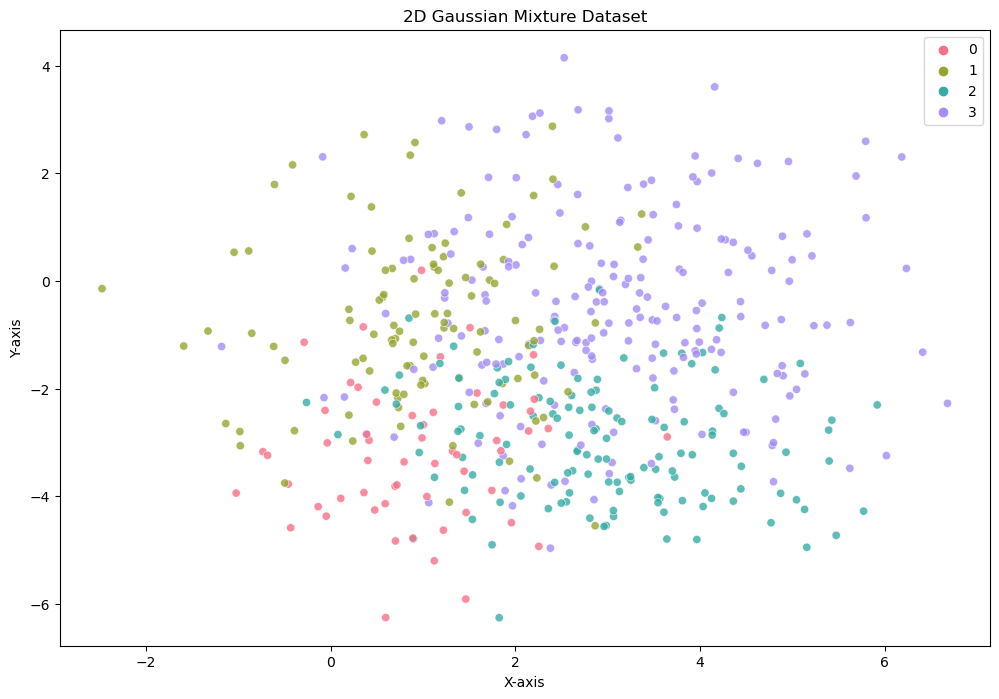

In [371]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, color='b', hue=labels, ax=ax, palette=custom_palette)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')

In [372]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.002)

In [373]:
som.fit(data, 400)

[[1.         0.31013469]
 [0.31013469 1.        ]]
[[1.         0.02399898]
 [0.02399898 1.        ]]
[[1.         0.51625018]
 [0.51625018 1.        ]]
[[1.         0.48063817]
 [0.48063817 1.        ]]
Epoch: 0
1/2*sigma^2: 1.002
Weights, Covariance:
[ 1.79941817 -2.96372288] [ 4.13659748 -2.78911828] [2.18709711 3.06202259] [-0.49730246 -3.75303065] 
Epoch: 1
1/2*sigma^2: 1.4170419894978414
Weights, Covariance:
[ 2.23750158 -1.42316159] [ 2.8252343  -2.09904858] [ 2.11261932 -0.57969754] [ 2.05177643 -1.70072333] 
Epoch: 2
1/2*sigma^2: 1.735514909184015
Weights, Covariance:
[ 2.06454447 -1.46716491] [ 2.98998745 -2.12997418] [ 2.11660656 -0.65249388] [ 2.23183631 -1.51774601] 
Epoch: 3
1/2*sigma^2: 2.004
Weights, Covariance:
[ 1.99353072 -1.64040584] [ 3.22030157 -2.41809157] [ 2.01899235 -0.08896026] [ 2.19317921 -1.59699479] 
Epoch: 4
1/2*sigma^2: 2.2405401134547893
Weights, Covariance:
[ 1.91816178 -1.74749574] [ 3.30832395 -2.56942148] [2.01532856 0.19915556] [ 2.16840972 -1.668

In [374]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

In [375]:
indexes = neuron_means[:, 0].argsort()

neuron_means = neuron_means[indexes]
neuron_variances = neuron_variances[indexes]

In [376]:
neuron_means

array([[ 1.16067397, -2.20849323],
       [ 1.65286809,  0.92273379],
       [ 3.23053504, -3.5304246 ],
       [ 3.57620032, -0.61579157]])

In [377]:
means

array([[ 1. , -3. ],
       [ 1. , -0.5],
       [ 2. , -3. ],
       [ 2. , -0.5]])

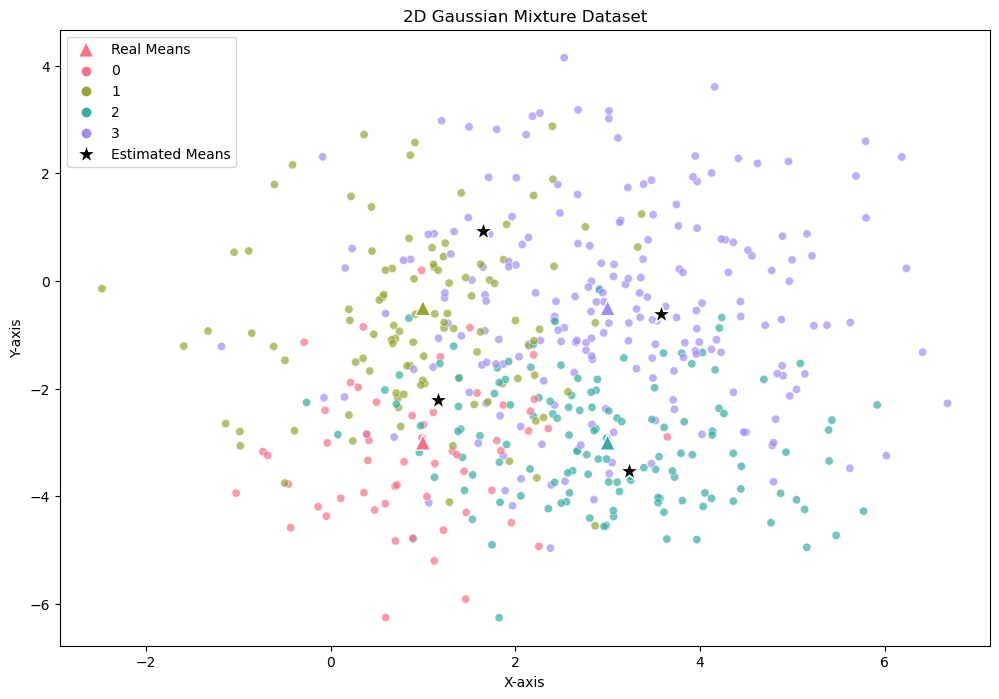

In [378]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette, legend=False)

means = np.array([(x, y) for x in means1 for y in means2])
sns.scatterplot(x=means[:, 0], y=means[:, 1], hue=np.unique(labels), marker='^', s=120, label='Real Means', palette=custom_palette, ax=ax)


# # Plot true parameters
# for mean, cov in zip(means, covariances):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
#     width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
#     ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='g', fill=False)
#     ax.add_patch(ell)

# Plot means as red points
sns.scatterplot(x=neuron_means[:, 0], y=neuron_means[:, 1], marker='*', s=220, label='Estimated Means', color='black', ax=ax)

# # Plot neuron parameters
# for mean, cov in zip(neuron_weights, neuron_variances):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
#     width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
#     ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='r', fill=False)
#     ax.add_patch(ell)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');